In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys 
from scipy.linalg import solve

In [157]:
CCOFile = 'Tree.cco'

In [158]:
def Viscosity(d, hd=0.45):
    mu045 = 220*np.exp(-1.3*d) + 3.2 - 2.44*np.exp(-0.06*d*0.645)
    C = (0.8 + np.exp(-0.075*d))*(-1+(1+10**-11*(d)**12)**-1)+(1+10**-11*(d)**12)**-1
    return 1 + (mu045-1)*((1-hd)**C-1)/((1-0.45)**C-1)

In [159]:
def ReadCCO(CCOFile):
    
    SegmentsData = []
    DistalNodes  = dict()
    
    nodeName = -1

    with open(CCOFile, 'r') as f:
        f.readline()
        f.readline()
        f.readline()
        f.readline()

        nVessels = int(f.readline())

        for i in range(nVessels):
            
            row = (f.readline()).split()
       
            if int(row[-1]) > -2:
                
                nodeName+=1
                DistalNodes[int(row[0])] = nodeName
                
                SegmentsData.append([int(row[0]),
                                     np.array([float(x) for x in row[1:4]])*1e4, 
                                     np.array([float(x) for x in row[4:7]])*1e4,
                                     float(row[12])*1e4,
                                     float(row[13]),
                                     nodeName,
                                     int(row[-1])]) # Id, xProx, xDist, radius, initial flow, distalNode, stage
        
        df = pd.DataFrame(SegmentsData, columns=['Id', 'xProx', 'xDist', 'Radius', 'InitFlow','DistalNode','Stage'])
        df['Inlet'] = False
        df['Outlet'] = False
        df = df.set_index('Id')
        df['ParentId'] = -1

        f.readline()
        f.readline()
        
        NodesConnections = []
        SegNewName = -1
        for i in range(nVessels):
            row = (f.readline()).split()
            SegmentId, ParentId, BranchesIds = int(row[0]), int(row[1]), [int(x) for x in row[2:]]

            if SegmentId in DistalNodes:    
                ProximalNode = DistalNodes[SegmentId]
                for connection in BranchesIds:
                    DistalNode = DistalNodes[connection]
                    SegNewName +=1
                    NodesConnections.append((ProximalNode, DistalNode, SegNewName, connection))
                    
                
                if not BranchesIds:
                    df.at[SegmentId, 'Outlet'] = True
                
                if not ParentId in DistalNodes: # Inlet node, need to add the proximal node to the tree
                    df.at[SegmentId, 'Inlet'] = True
                    nodeName+=1
                    SegNewName +=1
                    NodesConnections.append((nodeName, DistalNodes[SegmentId], SegNewName, SegmentId))
                else:
                    df.at[SegmentId, 'ParentId'] = ParentId

    ConnectivityMatrix = np.zeros((nodeName+1, len(SegmentsData)))
    Radii  = np.zeros((len(SegmentsData),))
    Length = np.zeros((len(SegmentsData),))
    df['SegName'] = df.index
    df['Id'] = df.index
    D = np.zeros((nodeName+1,nodeName+1)) # Decision matrix

    for proxNode, distNode, SegmentName, SegmentId in NodesConnections:
        
        ConnectivityMatrix[proxNode, SegmentName] = 1
        ConnectivityMatrix[distNode, SegmentName] = -1
        Radii[SegmentName] = df.at[SegmentId, 'Radius']
        xProx, xDist = df.at[SegmentId, 'xProx'], df.at[SegmentId, 'xDist']
        Length[SegmentName] = sum([(xProx[i]-xDist[i])**2 for i in range(3)])**.5
        
        df.at[SegmentId, 'SegName'] = SegmentName
        if df.at[SegmentId, 'Inlet']:
            D[proxNode, proxNode] = 1
            print('The inlet is at node:',proxNode)
        elif df.at[SegmentId, 'Outlet']:
            D[distNode, distNode] = -1
    
    df = df.set_index('SegName')
    

    ## Gives each inlet and its downstream branches a number
    df['BranchNumber'] = -1
    for i,row in enumerate(df[df.Inlet].iterrows()):
        df.at[row[0], 'BranchNumber'] = i

    for row in df[df.Inlet==False].iterrows():
        parentId = row[1].ParentId
        parent   = df[df.Id==parentId]
        idx = parent.index[0]
        currentBranchNumber = parent.at[idx,'BranchNumber']

        while currentBranchNumber==-1:
            parentId = df[df.Id==parent.at[idx,'ParentId']].ParentId
            print(parentId[1])
            parent   = df[df.Id==parentId]
            idx      = parent.index[0]
            currentBranchNumber = parent.at[idx,'BranchNumber']

        df.at[row[0], 'BranchNumber'] = currentBranchNumber
        currentBranchNumber = -1

        
    
    return ConnectivityMatrix.T, Radii, Length, D, df

In [160]:
Connectivity, Radii, Length, D, df = ReadCCO(CCOFile)

The inlet is at node: 763
The inlet is at node: 764
The inlet is at node: 765
The inlet is at node: 766
The inlet is at node: 767
The inlet is at node: 768
The inlet is at node: 769
The inlet is at node: 770
The inlet is at node: 771
The inlet is at node: 772


In [161]:
narcs, nnodes = Connectivity.shape
R = np.zeros((narcs,narcs))
for i in range(narcs):
    r,l = Radii[i], Length[i]
    mu  = Viscosity(2*r) 
    R[i,i] = 8.0*mu*l/(np.pi*(r**4))

In [162]:
# Add the boundary conditions
qperf = 0.3 # muL/min
qcap  = 0.1 # muL/min

# RHS for flow rates: qbar = qperf if inlet node, -qcap otherwise
qbar = np.ones((nnodes,)) # Flow rate at nodes
qbar = np.matmul(D,qbar)
qbar[qbar>0] *= qperf
qbar[qbar<0] *= qcap

pbar = np.ones((nnodes,))
pbar = D.dot(pbar)
pbar[pbar>0] = 25
pbar[pbar<0] = 15

In [163]:
# Solve the system
M = np.block([[
    R, -Connectivity],
    [Connectivity.T, D]])
      
RHS = np.concatenate([np.zeros(narcs,), qbar+pbar])
x = solve(M,RHS)
f,p = np.abs(x[:narcs]), x[narcs:]
dp  = np.abs(Connectivity.dot(p))

C:\Users\rhernand\Anaconda3\lib\site-packages\seaborn\_core.py:1194: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  x_visible = any(t.get_visible() for t in ax.get_xticklabels())
C:\Users\rhernand\Anaconda3\lib\site-packages\seaborn\relational.py:337: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  artist = func([], [], label=label, **use_kws)


<AxesSubplot:xlabel='Radius', ylabel='PressureDrop'>

C:\Users\rhernand\Anaconda3\lib\site-packages\ipykernel\pylab\backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


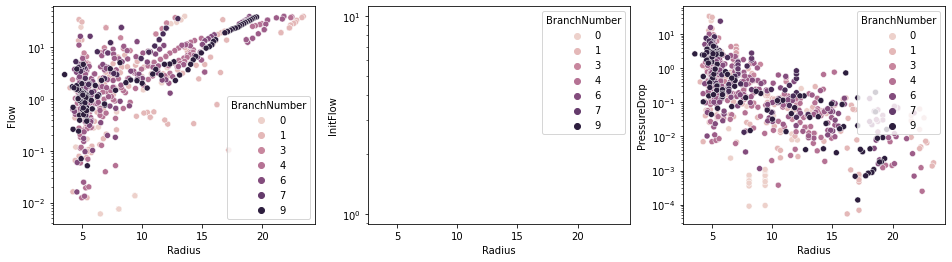

In [164]:
df['Flow'] = f
df['PressureDrop'] = dp 

for i in range(f.shape[0]):
    df.at[i,'Flow'] = f[i]
    df.at[i,'PressureDrop'] = dp[i]

fig, axes = plt.subplots(1,3, figsize=(16,4))
for ax in axes:
    ax.set(yscale='log')
sns.scatterplot(data=df, x='Radius', y='Flow', hue='BranchNumber', ax=axes[0])
sns.scatterplot(data=df, x='Radius', y='InitFlow', hue='BranchNumber', ax=axes[1])
sns.scatterplot(data=df, x='Radius', y='PressureDrop' , hue='BranchNumber', ax=axes[2])

In [166]:
for i in range(10):
    termCap = df[df.Outlet & df.BranchNumber==i].shape[0]
    print(f'Branch {i} has {termCap} terminal capillaries.')

Branch 0 has 43 terminal capillaries.
Branch 1 has 154 terminal capillaries.
Branch 2 has 13 terminal capillaries.
Branch 3 has 35 terminal capillaries.
Branch 4 has 141 terminal capillaries.
Branch 5 has 123 terminal capillaries.
Branch 6 has 90 terminal capillaries.
Branch 7 has 21 terminal capillaries.
Branch 8 has 39 terminal capillaries.
Branch 9 has 104 terminal capillaries.
